In [2]:
import pandas as pd
from collections import Counter
import numpy as np
from pycaret.classification import ClassificationExperiment
import polars

- The dataset is from the [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/overview)  kaggle competition. 
- Goal of the competition is predict credit default based on the customer's monthly profile.
- For each customer, 189 features are provided in the dataset

In [3]:
train_data = pd.read_feather('../data/train_data.ftr')

In [4]:
train_data.shape

(5531451, 191)

In [20]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


The features for each customer are divided into the following 5 categories:
  1. D_* = Delinquency variables
  2. S_* = Spend variables
  3. P_* = Payment variables
  4. B_* = Balance variables
  5. R_* = Risk variables

In [5]:
count_of_feature_type = Counter([
    x.split('_')[0] for x in train_data.columns
    if x not in ['customer_ID', 'target']
])
count_of_feature_type = pd.DataFrame(count_of_feature_type, index=['count']).T
count_of_feature_type

,count
S,22
P,3
D,96
B,40
R,28


0    0.750903
1    0.249097
Name: target, dtype: float64


<AxesSubplot: title={'center': 'Target Distribution'}>

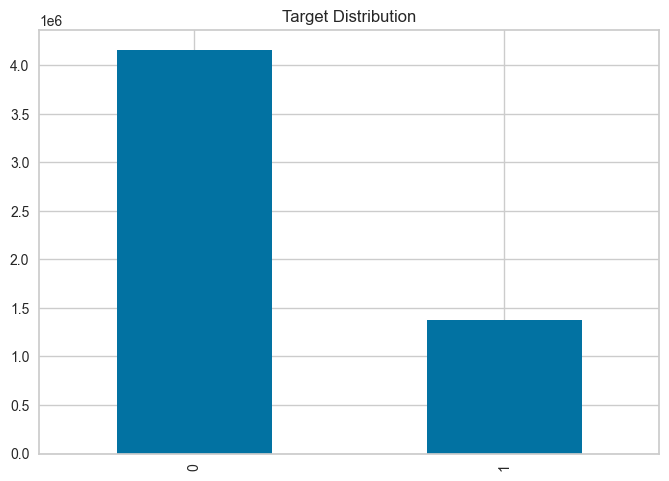

In [6]:
# calculate the percentage of training data that is 1 and 0
print(train_data['target'].value_counts(normalize=True))
train_data['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution')


In [25]:
train_data = train_data.sort_values(by=['customer_ID', 'S_2'])

In [26]:
# Extract the date information from the date column
train_data['Month'] = [i.month for i in train_data['S_2']]
train_data['Day'] = [i.day for i in train_data['S_2']]
train_data['Year'] = [i.year for i in train_data['S_2']]



In [27]:
# pick random 5000 customer_ID from train_data
np.random.seed(42)
customer_ID_rand = np.random.choice(train_data['customer_ID'], 5000, replace=False)

In [28]:
train_rndm_sample = train_data[train_data['customer_ID'].isin(customer_ID_rand)]

0    0.763853
1    0.236147
Name: target, dtype: float64


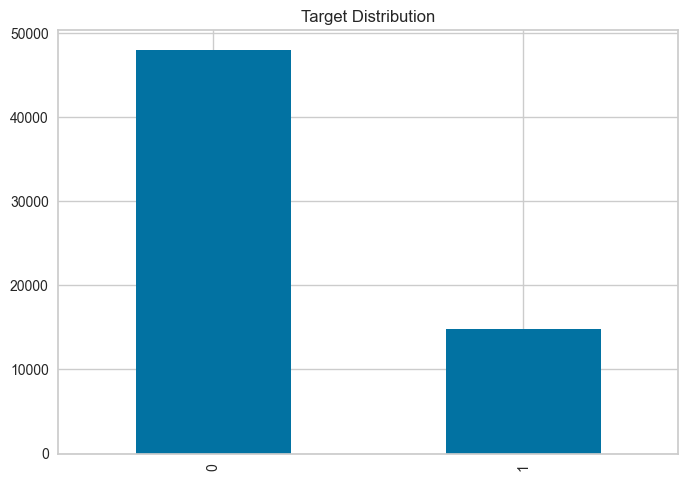

In [29]:
# calculate the percentage of training data sample that is 1 and 0
print(train_rndm_sample['target'].value_counts(normalize=True))
train_rndm_sample['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution');

<AxesSubplot: title={'center': 'Distribution of number of records per customer_ID'}, ylabel='Frequency'>

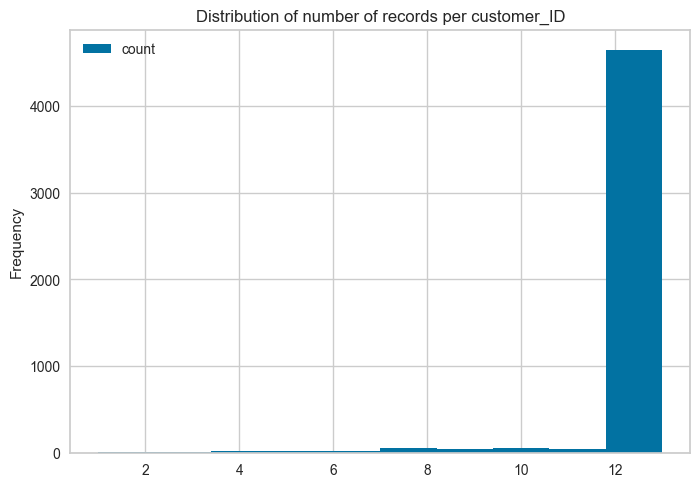

In [30]:
# calculate the number of records per customer_ID
records_per_cust = train_rndm_sample.groupby(
    'customer_ID').size().reset_index().rename(columns={
        0: 'count'
    }).sort_values(by='count', ascending=False)

# plot the distribution of number of records per customer_ID
records_per_cust.plot(
    kind='hist', title='Distribution of number of records per customer_ID')


In [40]:
s = ClassificationExperiment()
s.setup(data=train_rndm_sample, target='target', normalize=True, session_id=123)          

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(62728, 191)"
4,Transformed data shape,"(62728, 224)"
5,Transformed train set shape,"(43909, 224)"
6,Transformed test set shape,"(18819, 224)"
7,Ordinal features,4
8,Numeric features,177
9,Date features,1


In [41]:
best = s.compare_models()

In [42]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

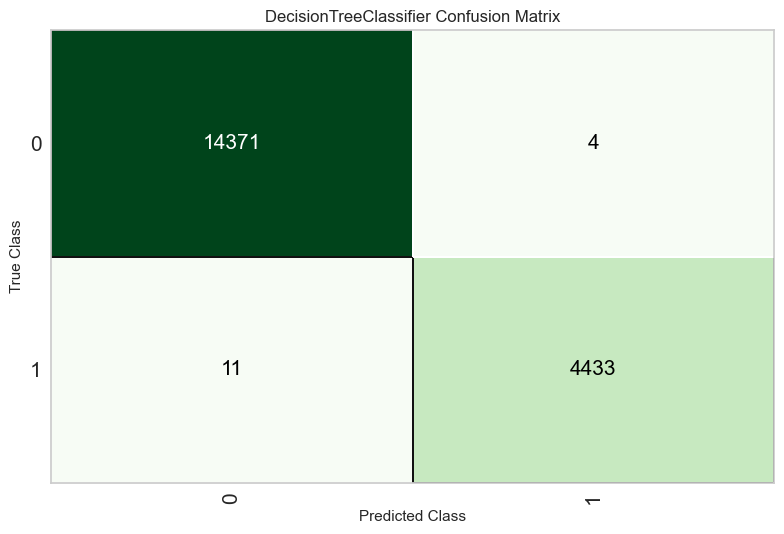

In [43]:
s.plot_model(best, plot = 'confusion_matrix')

In [44]:
s.save_model(best, 'first_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/st/9fkv5y5s4dqd7g46g06m83br0000gn/T/joblib),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['S_2'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['P_2', 'D_39', 'B_1', 'B_2', 'R_1',
                                              'S_3', 'D_41'...
                                     transformer=StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True))),
                 ('trained_model',
         

In [45]:
s.load_model('first_pipeline')

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/var/folders/st/9fkv5y5s4dqd7g46g06m83br0000gn/T/joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['S_2'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['P_2', 'D_39', 'B_1', 'B_2', 'R_1',
                                             'S_3', 'D_41'...
                                    transformer=StandardScaler(copy=True,
                                                               with_mean=True,
                                                               with_std=True))),
                ('trained_model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        random_state=123, splitter='best'))],
         verbose=False)

In [46]:
s.get_config()

{'USI',
 'X',
 'X_test',
 'X_test_transformed',
 'X_train',
 'X_train_transformed',
 'X_transformed',
 '_available_plots',
 '_ml_usecase',
 'data',
 'dataset',
 'dataset_transformed',
 'exp_id',
 'exp_name_log',
 'fix_imbalance',
 'fold_generator',
 'fold_groups_param',
 'fold_shuffle_param',
 'gpu_n_jobs_param',
 'gpu_param',
 'html_param',
 'idx',
 'is_multiclass',
 'log_plots_param',
 'logging_param',
 'memory',
 'n_jobs_param',
 'pipeline',
 'seed',
 'target_param',
 'test',
 'test_transformed',
 'train',
 'train_transformed',
 'variable_and_property_keys',
 'variables',
 'y',
 'y_test',
 'y_test_transformed',
 'y_train',
 'y_train_transformed',
 'y_transformed'}

In [47]:
pd.DataFrame(s.pull()).sort_values('F1', ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9993,1.0000,0.9976,0.9995,0.9986,0.9981,0.9981,2.461
xgboost,Extreme Gradient Boosting,0.9993,1.0000,0.9977,0.9995,0.9986,0.9982,0.9982,1.829
dt,Decision Tree Classifier,0.9993,0.9989,0.9982,0.9987,0.9985,0.9980,0.9980,0.237
rf,Random Forest Classifier,0.9992,0.9999,0.9966,1.0000,0.9983,0.9978,0.9978,2.370
gbc,Gradient Boosting Classifier,0.9992,1.0000,0.9966,0.9999,0.9983,0.9977,0.9977,12.536
et,Extra Trees Classifier,0.9992,1.0000,0.9964,1.0000,0.9982,0.9977,0.9977,0.749
catboost,CatBoost Classifier,0.9992,1.0000,0.9965,0.9999,0.9982,0.9977,0.9977,5.949
lr,Logistic Regression,0.9991,0.9999,0.9961,0.9999,0.9980,0.9974,0.9974,0.323
ridge,Ridge Classifier,0.9990,0.0000,0.9956,1.0000,0.9978,0.9971,0.9971,0.176
lda,Linear Discriminant Analysis,0.9990,0.9978,0.9956,1.0000,0.9978,0.9971,0.9971,0.430


In [33]:
s = ClassificationExperiment()
s.setup(data=train_rndm_sample, target='target', normalize=True, session_id=123, fold_strategy='timeseries', fix_imbalance=True, log_experiment=True, experiment_name='timeseries_fold', data_split_shuffle = False,data_split_stratify = False)

In [34]:
best = s.compare_models()
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [36]:
pd.DataFrame(s.pull()).sort_values('F1', ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8046,0.8456,0.7686,0.5662,0.6518,0.5202,0.5322,0.884
dt,Decision Tree Classifier,0.6041,0.4995,0.2923,0.2361,0.1975,-0.0014,0.0008,0.235
nb,Naive Bayes,0.6189,0.5519,0.3348,0.5576,0.1778,0.0509,0.1090,0.218
qda,Quadratic Discriminant Analysis,0.6263,0.5529,0.3259,0.5560,0.1743,0.0503,0.1107,0.247
svm,SVM - Linear Kernel,0.7791,0.0000,0.1089,0.6585,0.1719,0.1306,0.1926,0.258
et,Extra Trees Classifier,0.7799,0.8982,0.1084,0.8744,0.1633,0.1279,0.2201,0.468
catboost,CatBoost Classifier,0.7201,0.7278,0.1650,0.1973,0.1348,0.0717,0.0915,6.349
lr,Logistic Regression,0.7757,0.9036,0.0830,0.8671,0.1279,0.0999,0.1804,0.695
lightgbm,Light Gradient Boosting Machine,0.6174,0.5304,0.2905,0.2055,0.1251,0.0059,0.0134,0.542
xgboost,Extreme Gradient Boosting,0.6551,0.7443,0.2102,0.4263,0.0937,0.0138,0.0401,1.793
